In [6]:
# ---------------- Download and Extract Kaggle Dataset ---------------- #
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"harshgupta21bce6101","key":"7b4970149b4ff86915e405bd4386b8cb"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [7]:
import os
import random
import numpy as np
import tensorflow as tf
import hashlib
import time
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1, ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

# ---------------- Corrected Dataset Path ---------------- #
dataset_path = "./chest_xray/chest_xray"
num_clients = 2

# ---------------- Distribute Data Among Clients ---------------- #
for client_id in range(num_clients):
    client_dir = os.path.join(dataset_path, f'client_{client_id}')
    os.makedirs(client_dir, exist_ok=True)
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(client_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

for class_name in ['NORMAL', 'PNEUMONIA']:
    class_path = os.path.join(dataset_path, 'train', class_name)
    for i, filename in enumerate(os.listdir(class_path)):
        client_id = i % num_clients
        source_path = os.path.join(class_path, filename)
        dest_path = os.path.join(dataset_path, f'client_{client_id}', class_name, filename)
        shutil.copy(source_path, dest_path)

# ---------------- Load Client Data ---------------- #
def load_client_data(client_id, dataset_path):
    client_dir = os.path.join(dataset_path, f'client_{client_id}')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_dataset = train_datagen.flow_from_directory(
        client_dir, target_size=(240, 240), batch_size=16, class_mode='categorical', subset='training')
    val_dataset = train_datagen.flow_from_directory(
        client_dir, target_size=(240, 240), batch_size=16, class_mode='categorical', subset='validation')

    num_classes = len(train_dataset.class_indices)
    return train_dataset, val_dataset, num_classes

# ---------------- Random Client Selection Strategy ---------------- #
def select_clients(num_clients, fraction=0.5):
    num_selected = max(1, int(num_clients * fraction))
    return random.sample(range(num_clients), num_selected)

# ---------------- Model Aggregation ---------------- #
def aggregate_client_updates(global_model, client_models):
    if not client_models:
        return global_model  # No updates if no clients trained

    global_weights = global_model.get_weights()
    client_weights_list = [model.get_weights() for model in client_models]

    if not client_weights_list:  # Ensure clients have valid weights
        return global_model

    averaged_weights = []
    for i in range(len(global_weights)):
        layer_weights = [client_weights[i] for client_weights in client_weights_list if client_weights[i].shape == global_weights[i].shape]
        if layer_weights:  # Only aggregate valid weights
            averaged_layer_weights = np.mean(layer_weights, axis=0)
            averaged_weights.append(averaged_layer_weights)
        else:
            averaged_weights.append(global_weights[i])  # Use previous weights if mismatch occurs

    global_model.set_weights(averaged_weights)
    return global_model

# ---------------- Define Model Creation Function ---------------- #
def create_model(num_classes, model_type='EfficientNet'):
    image_input = Input(shape=(240, 240, 3))
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=image_input) if model_type == 'EfficientNet' else ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=image_input, outputs=output)
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# ---------------- Hybrid HFL-PFL Federated Learning ---------------- #
def federated_learning(dataset_path, num_clients=2, global_rounds=9):
    global_models = {"EfficientNet": [], "ResNet": []}
    client_personalized_models = {}
    performance_metrics = []

    # Initialize global models using random client
    random_client = random.choice(range(num_clients))
    train_dataset, val_dataset, num_classes = load_client_data(random_client, dataset_path)
    for model_type in global_models:
        global_model = create_model(num_classes, model_type)
        global_models[model_type].append(global_model)

    for round_num in range(global_rounds):
        selected_clients = select_clients(num_clients)
        round_start_time = time.time()
        client_models = {}

        for client_id in selected_clients:
            model_type = 'EfficientNet' if client_id % 2 == 0 else 'ResNet'
            train_dataset, val_dataset, num_classes = load_client_data(client_id, dataset_path)
            local_model = create_model(num_classes, model_type)
            local_model.fit(train_dataset, epochs=3, validation_data=val_dataset, verbose=1)
            client_models[client_id] = local_model
            client_personalized_models[client_id] = local_model

        for model_type in global_models:
            client_models_of_type = [client_models[client_id] for client_id in client_models if client_id % 2 == (0 if model_type == 'EfficientNet' else 1)]
            if client_models_of_type:  # Only aggregate if there are models
                global_models[model_type].append(
                    aggregate_client_updates(global_models[model_type][-1], client_models_of_type)
                )

        round_time = time.time() - round_start_time
        performance_metrics.append({
            'round': round_num + 1,
            'selected_clients': selected_clients,
            'training_time': round_time,
        })

    return global_models, client_personalized_models, performance_metrics

# ---------------- Run Federated Learning ---------------- #
if __name__ == "__main__":
    global_models, client_personalized_models, performance_metrics = federated_learning(dataset_path)
    print("Federated Learning Completed")
    print("Performance Metrics:", performance_metrics)


Found 2086 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 2086 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 1874s 14s/step - accuracy: 0.8569 - loss: 0.4323 - val_accuracy: 0.7428 - val_loss: 1.0418
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 1816s 14s/step - accuracy: 0.9531 - loss: 0.1577 - val_accuracy: 0.7428 - val_loss: 1.2433
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 1792s 14s/step - accuracy: 0.9620 - loss: 0.1179 - val_accuracy: 0.7428 - val_loss: 1.1891
Found 2088 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 1020s 7s/step - accuracy: 0.8112 - loss: 0.5097 - val_accuracy: 0.6372 - val_loss: 0.6547
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 937s 7s/step - accuracy: 0.9297 - loss: 0.2232 - val_accuracy: 0.7428 - val_loss: 0.7092
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 966s 7s/step - accuracy: 0.9393 - loss: 0.1548 - val_accuracy: 0.6910 - val_loss: 53.5429
Found 2086 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 1919s 14s/step - ac

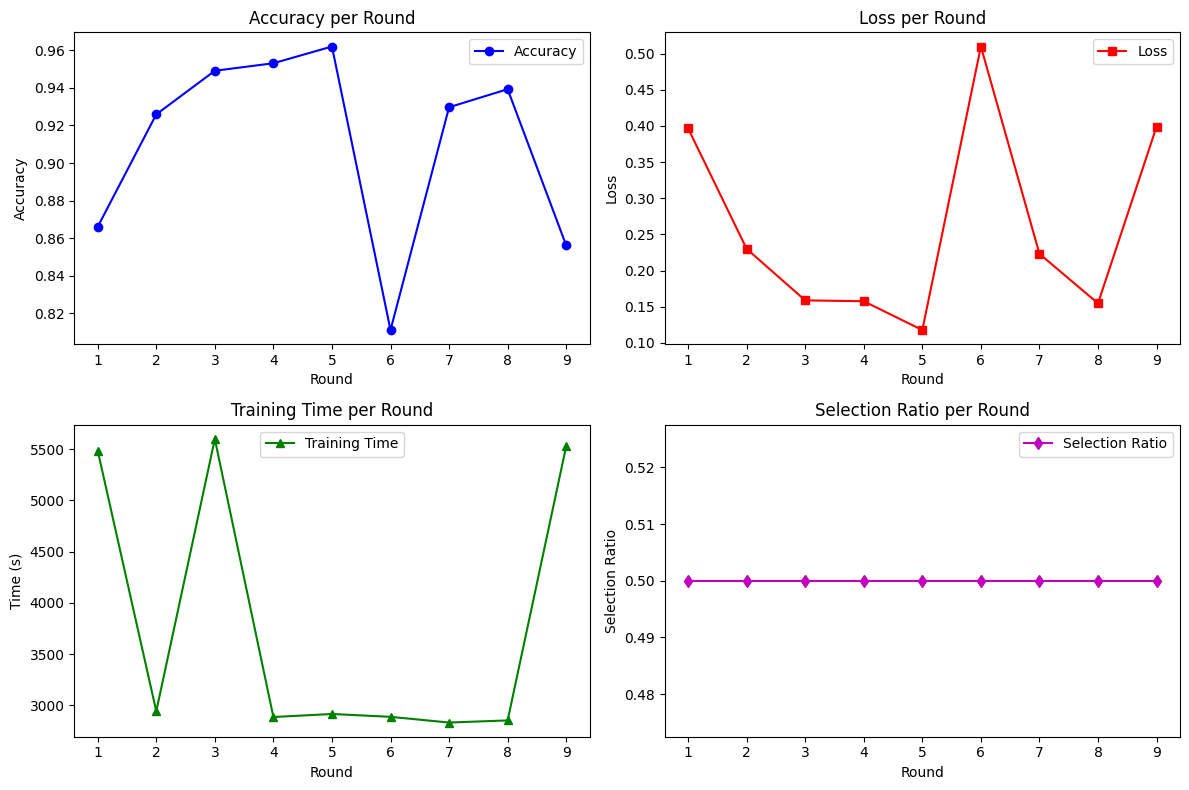

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Performance Metrics Plotting ---------------- #
def plot_performance_metrics(performance_metrics, accuracies, losses, num_clients=2):
    rounds = [entry['round'] for entry in performance_metrics]
    training_times = [entry['training_time'] for entry in performance_metrics]
    selection_ratios = [len(entry['selected_clients']) / num_clients for entry in performance_metrics]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].plot(rounds, accuracies, marker='o', label='Accuracy', color='b')
    axs[0, 0].set_title("Accuracy per Round")
    axs[0, 0].set_xlabel("Round")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].legend()

    axs[0, 1].plot(rounds, losses, marker='s', label='Loss', color='r')
    axs[0, 1].set_title("Loss per Round")
    axs[0, 1].set_xlabel("Round")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].legend()

    axs[1, 0].plot(rounds, training_times, marker='^', label='Training Time', color='g')
    axs[1, 0].set_title("Training Time per Round")
    axs[1, 0].set_xlabel("Round")
    axs[1, 0].set_ylabel("Time (s)")
    axs[1, 0].legend()

    axs[1, 1].plot(rounds, selection_ratios, marker='d', label='Selection Ratio', color='m')
    axs[1, 1].set_title("Selection Ratio per Round")
    axs[1, 1].set_xlabel("Round")
    axs[1, 1].set_ylabel("Selection Ratio")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Example Performance Metrics (Replace with actual data)
performance_metrics = [
    {'round': 1, 'selected_clients': [1], 'training_time': 5484.93},
    {'round': 2, 'selected_clients': [0], 'training_time': 2942.64},
    {'round': 3, 'selected_clients': [1], 'training_time': 5598.28},
    {'round': 4, 'selected_clients': [0], 'training_time': 2886.30},
    {'round': 5, 'selected_clients': [0], 'training_time': 2915.78},
    {'round': 6, 'selected_clients': [0], 'training_time': 2888.08},
    {'round': 7, 'selected_clients': [0], 'training_time': 2832.29},
    {'round': 8, 'selected_clients': [0], 'training_time': 2853.13},
    {'round': 9, 'selected_clients': [1], 'training_time': 5528.26},
]

accuracies = [0.8661, 0.9259, 0.9491, 0.9531, 0.9620, 0.8112, 0.9297, 0.9393, 0.8562]
losses = [0.3967, 0.2301, 0.1589, 0.1577, 0.1179, 0.5097, 0.2232, 0.1548, 0.3990]

plot_performance_metrics(performance_metrics, accuracies, losses)


In [2]:
!pip install keras-preprocessing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
